In [1]:
import numpy as np
import pandas as pd
import umap
from umap import UMAP
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

In [2]:
#Load the normalized single-cell RNA sequencing data
df = pd.read_csv('data.csv', index_col=0)

df.head()

,AAACCCAAGAGTCTTC_1,AAACCCAAGGACTTCT_1,AAACCCAGTCACCACG_1,AAACCCAGTCACTCTC_1,AAACCCAGTTCCTTGC_1,AAACCCATCACTGAAC_1,AAACCCATCCTGCTAC_1,AAACCCATCGTTGTTT_1,AAACCCATCTTAGCAG_1,AAACGAAAGTTACGTC_1,...,TTTGGAGCAATTGCTG-1_4,TTTGGAGCAGCTACTA-1_4,TTTGGAGCATCAACCA-1_4,TTTGGAGCATTGCAAC-1_4,TTTGGAGGTAGAGGAA-1_4,TTTGGAGGTCTTTCAT-1_4,TTTGGAGGTTTGGAAA-1_4,TTTGGTTCAGTGGCTC-1_4,TTTGGTTTCTTTACAC-1_4,TTTGTTGGTCGTCATA-1_4
Xkr4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Mrpl15,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,...,0.0,0.0,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Lypla1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Create an AnnData Object that will be used for downstream analyzes.
adata = sc.AnnData(df.T)

In [4]:
# Perform UMAP clustering according to the parameters used by the original paper
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=20)
sc.tl.umap(adata, random_state=4)

sc.tl.leiden(adata, resolution=0.3)

In [7]:
#Create a list of the cluster assignments.
leiden_cluster = []
for i in range(len(adata.obs['leiden'])):
    leiden_cluster.append(int(adata.obs['leiden'].iloc[i]))

In [12]:
adata

AnnData object with n_obs × n_vars = 21458 × 18597
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
type(adata.obsp)

anndata._core.aligned_mapping.PairwiseArrays

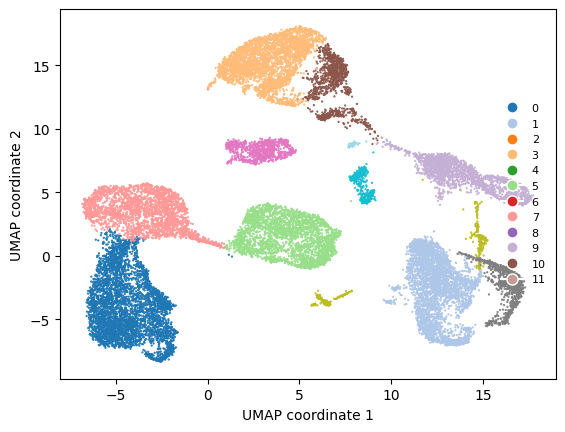

In [6]:
#Visualize the UMAP
umap_coords = adata.obsm['X_umap']

plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=leiden_cluster, cmap='tab20', s=0.35)

plt.xlabel('UMAP coordinate 1')
plt.ylabel('UMAP coordinate 2')

legend_labels = list(set(leiden_cluster))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                             markerfacecolor=plt.cm.tab20(legend_labels.index(label)),
                             markersize=8) for label in legend_labels]

plt.legend(handles=legend_handles, loc='right',  fontsize=8, frameon=False)
plt.show()

In [30]:
#Find marker genes using Wilcoxon test as in the paper
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

/Users/muzhou/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [31]:
#Create a data frame with the top 10 significant marker genes
marker_genes_by_cluster = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top10_markers = marker_genes_by_cluster.iloc[:10, ]

In [32]:
#Load the data fram the authors used as marker genes
markers = pd.read_csv('Marker Gene List.csv')

markers.head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
0,0.0,5.029657,1.0,0.084,0.0,Microglia,C1qb
1,0.0,5.007141,1.0,0.073,0.0,Microglia,C1qa
2,0.0,4.886182,1.0,0.130,0.0,Microglia,Hexb
3,0.0,4.882157,1.0,0.066,0.0,Microglia,Ctss
4,0.0,4.582569,1.0,0.055,0.0,Microglia,C1qc


In [10]:
#Create a data frame that identifies cell type based on the marker genes for each cluster
cell_type_df = pd.DataFrame(index=top10_markers.index, columns=top10_markers.columns)

for col in top10_markers.columns:
    for i, gene in enumerate(top10_markers[col]):
        if gene in markers['gene'].values:
            cell_type_df.loc[i, col] = markers.loc[markers['gene'] == gene, 'cluster'].values[0]

cell_type_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,Neuroblast,Oligodendro,Microglia,Astrocyte_qNSC,NaN,NaN,NaN,Endothelial,Oligodendro,Neuron,Mural,Ependymal
1,Neuroblast,Oligodendro,NaN,Astrocyte_qNSC,aNSC_NPC,NaN,NaN,Endothelial,NaN,Neuron,Mural,Ependymal
2,Neuroblast,Oligodendro,NaN,Astrocyte_qNSC,aNSC_NPC,NaN,NaN,Endothelial,OPC,NaN,Mural,Ependymal
3,Neuroblast,NaN,Microglia,Astrocyte_qNSC,NaN,OPC,Microglia,Endothelial,NaN,NaN,NaN,Ependymal
4,Neuroblast,Oligodendro,Microglia,Astrocyte_qNSC,NaN,Oligodendro,Microglia,Endothelial,Oligodendro,NaN,Mural,NaN
5,Neuroblast,NaN,NaN,Astrocyte_qNSC,aNSC_NPC,NaN,NaN,Endothelial,NaN,NaN,Mural,Ependymal
6,Neuroblast,Oligodendro,Microglia,Astrocyte_qNSC,NaN,Oligodendro,Microglia,NaN,OPC,NaN,NaN,NaN
7,Neuroblast,Oligodendro,NaN,Astrocyte_qNSC,NaN,NaN,NaN,Endothelial,NaN,NaN,NaN,Ependymal
8,Neuroblast,NaN,Microglia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,OPC,NaN,Astrocyte_qNSC,aNSC_NPC,NaN,Macrophage,NaN,NaN,NaN,NaN,Ependymal


In [11]:
#Get a list of the most frequent cell type in that cluster
cell_type_list = cell_type_df.mode(axis=0).iloc[0]

cell_type_list

0         Neuroblast
1        Oligodendro
2          Microglia
3     Astrocyte_qNSC
4           aNSC_NPC
5        Oligodendro
6          Microglia
7        Endothelial
8                OPC
9             Neuron
10             Mural
11         Ependymal
Name: 0, dtype: object

In [12]:
#Manually annotate ambiguous cell types
cell_type_list_adj = ['Neuroblast', 'Oligodendro_1', 'Microglia_1', 'Astrocyte_qNSC', 'aNSC_NPC', 'Oligodendro_2', 'Microglia_2', 'Endothelial', 'OPC', 'Neuron', 'Mural', 'Ependymal']


In [13]:
#Create a dict that maps cluster to cell type  
cluster_label_dict = {}
for i in range(len(cell_type_list_adj)):
    if i < len(cell_type_list):
        cluster_label_dict[i] = cell_type_list_adj[i]

In [14]:
cluster_label_dict

{0: 'Neuroblast',
 1: 'Oligodendro_1',
 2: 'Microglia_1',
 3: 'Astrocyte_qNSC',
 4: 'aNSC_NPC',
 5: 'Oligodendro_2',
 6: 'Microglia_2',
 7: 'Endothelial',
 8: 'OPC',
 9: 'Neuron',
 10: 'Mural',
 11: 'Ependymal'}

In [15]:
#Add the cell type as a new column
adata.obs['new_cluster_labels'] = None

#Re-label the clusters with identified cell types
for i in range(len(adata.obs['leiden'])):
    adata.obs['new_cluster_labels'].iloc[i] = cluster_label_dict[int(adata.obs['leiden'].iloc[i])]

/var/folders/3x/mfxgjhb13zxb7kdd9vl85m0w0000gn/T/ipykernel_94838/2554488369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['new_cluster_labels'].iloc[i] = cluster_label_dict[int(adata.obs['leiden'].iloc[i])]


Text(-7.5, -9, '21458 cells')

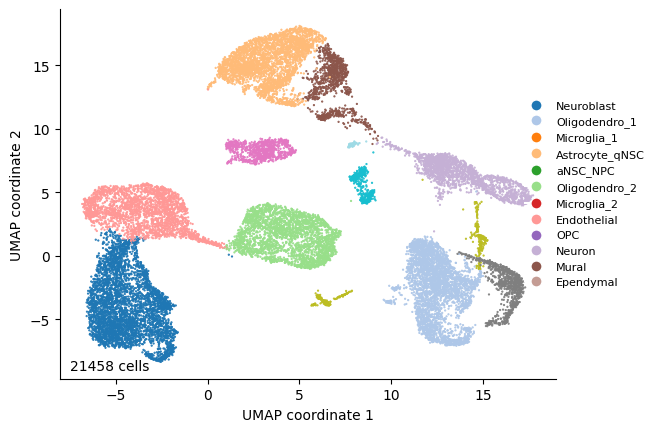

In [16]:
#Re-plot the UMAP
umap_coords = adata.obsm['X_umap']

plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=leiden_cluster, cmap='tab20', s=0.35)

plt.xlabel('UMAP coordinate 1')
plt.ylabel('UMAP coordinate 2')

legend_labels = cell_type_list_adj
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                             markerfacecolor=plt.cm.tab20(legend_labels.index(label)),
                             markersize=8) for label in legend_labels]

plt.legend(handles=legend_handles, bbox_to_anchor=(1.2, 0.5), loc='right', fontsize=8, frameon=False)

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.text(-7.5, -9, f"{df.shape[1]} cells", fontsize=10, color='black')

In [33]:
#Create a data frame with the top 10 significant marker genes
top5_markers = marker_genes_by_cluster.iloc[:5, ]

top5_markers

,0,1,2,3,4,5,6,7,8,9,10,11
0,Sox4,Cryab,Hexb,Slc1a2,Hmgb1,Aplp1,Rps29,Ly6c1,Gatm,Olig1,Cald1,Fam183b
1,Rtn1,Plp1,Lgmn,Plpp3,H2afz,Tubb4a,Fau,Ly6a,Gstp1,Cntn1,Igfbp7,Ccdc153
2,Stmn2,Gatm,Gpr34,Mt3,Hmgb2,Ttll7,Rplp1,Bsg,Cnp,Malat1,Myl9,Tmem212
3,Tmsb10,Rnf7,Ly86,Aldoc,Ran,Mag,Ctss,Pltp,Dpysl2,Pllp,Higd1b,Rarres2
4,Meis2,Fth1,C1qc,Clu,H2afv,Apod,Tyrobp,Klf2,Mbp,Tspan3,Rgs5,Dynlrb2


In [34]:
#Get all the top marker genes into a list
top5_markers_list = []

for column in top5_markers.columns:
    top5_markers_list.extend(top5_markers[column].tolist())

In [35]:
#Subset the adata to only contain the top marker genes
adata_subset = adata[:, top5_markers_list]

In [36]:
#Subset the expression data from the adata_subset
expression_data = adata_subset.X.toarray()

In [37]:
expression_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.69314718, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.09861229, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.79175947, 2.83321334, 2.7080502 , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
#Create a list of cluster labels for the subset data
cluster_list = []

for i in range(len(adata_subset.obs['new_cluster_labels'])):
    cluster_list.append(adata_subset.obs['new_cluster_labels'].iloc[i])

In [22]:
# Combine gene expression data and cluster labels into a DataFrame
heatmap_df = pd.DataFrame(expression_data, columns=top5_markers_list)
heatmap_df['Cluster'] = cluster_list

In [23]:
#Sort the data frame so that it is grouped in cluster labels
df_sorted = heatmap_df.sort_values(by='Cluster')
#Set the cluster labels as the new indecies
df_sorted.set_index('Cluster', inplace=True)

df_sorted.head()

,Sox4,Rtn1,Stmn2,Tmsb10,Meis2,Cryab,Plp1,Gatm,Rnf7,Fth1,...,Cald1,Igfbp7,Myl9,Higd1b,Rgs5,Fam183b,Ccdc153,Tmem212,Rarres2,Dynlrb2
Cluster,,,,,,,,,,,,,,,,,,,,,
Astrocyte_qNSC,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.637586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Astrocyte_qNSC,0.000000,0.0,0.0,0.0,1.098612,1.098612,0.000000,0.000000,1.098612,2.564949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Astrocyte_qNSC,0.000000,0.0,0.0,0.0,0.000000,1.098612,0.693147,0.000000,1.098612,3.465736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Astrocyte_qNSC,0.000000,0.0,0.0,0.0,1.098612,0.000000,1.098612,1.098612,0.000000,2.708050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Astrocyte_qNSC,0.000000,0.0,0.0,0.0,0.693147,1.609438,0.693147,0.000000,0.000000,3.433987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Log transform the data to match the expression levels that range from -2 to 2
small_constant = 1e-5
log_transformed_data = np.log1p(df_sorted + small_constant)
scaler = MinMaxScaler(feature_range=(-2, 2))
scaled_data = scaler.fit_transform(df_sorted)

#Save the transformed data into a data frame
scaled_df = pd.DataFrame(scaled_data, columns=df_sorted.columns, index=df_sorted.index)

In [25]:
scaled_df.head()

,Sox4,Rtn1,Stmn2,Tmsb10,Meis2,Cryab,Plp1,Gatm,Rnf7,Fth1,...,Cald1,Igfbp7,Myl9,Higd1b,Rgs5,Fam183b,Ccdc153,Tmem212,Rarres2,Dynlrb2
Cluster,,,,,,,,,,,,,,,,,,,,,
Astrocyte_qNSC,-1.311218,-2.0,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.279969,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Astrocyte_qNSC,-2.000000,-2.0,-2.0,-2.0,-0.773706,-1.101404,-2.000000,-2.000000,-0.634788,-0.392339,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Astrocyte_qNSC,-2.000000,-2.0,-2.0,-2.0,-2.000000,-1.101404,-1.523859,-2.000000,-0.634788,0.172257,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Astrocyte_qNSC,-2.000000,-2.0,-2.0,-2.0,-0.773706,-2.000000,-1.245335,-0.908307,-2.000000,-0.302646,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Astrocyte_qNSC,-2.000000,-2.0,-2.0,-2.0,-1.226294,-0.683580,-1.523859,-2.000000,-2.000000,0.152357,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


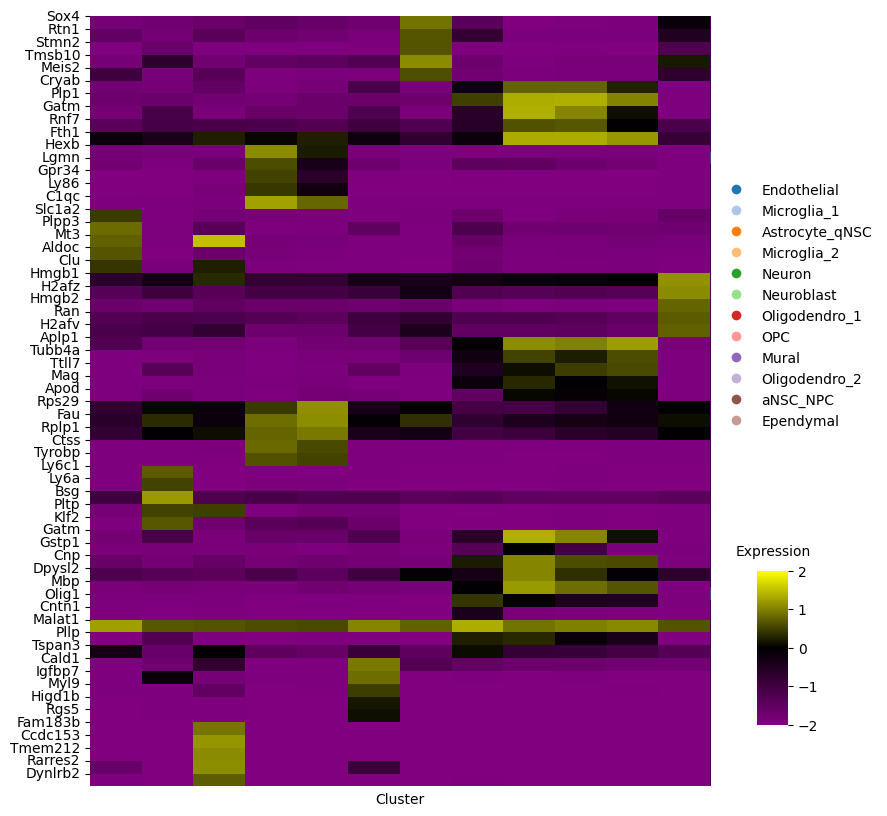

In [26]:
#Plot the heat map
clustered_df = scaled_df.groupby('Cluster').mean()
plt.figure(figsize=(10, 10))

#Adjust color theme
cmap = LinearSegmentedColormap.from_list('custom', ['purple', 'black', 'yellow'])

heatmap = sns.heatmap(clustered_df.T, cmap=cmap, vmin=-2, vmax=2, cbar_kws={'shrink': 0.2, 'aspect': 5, 'anchor': (0.1, 0.1)})

#Get all the genes as row labels
heatmap.set_yticks(range(len(clustered_df.T.index)))
heatmap.set_yticklabels(clustered_df.T.index)

heatmap.set_xticks([])

#Adjust the color bar
cbar_ax = heatmap.figure.axes[-1]
cbar_ax.set_title('')
cbar_ax.set_xlabel('Expression', labelpad=-130) 

#Create and plot the legends
unique_labels = list(set(scaled_df.index))
label_to_color = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}
column_colors = [label_to_color[label] for label in scaled_df.index]

plt.imshow(scaled_df, cmap='viridis', aspect='auto')

color_bar_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10) for label in unique_labels]
plt.legend(legend_handles, unique_labels, title='', bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False)


plt.show()